# Analysis of Annif suggestions in Theseus repository    

## Install and import packages
In VS Code the simplest way to install packages in correct venv is to do it in the notebook.

In [1]:
! pip install --upgrade pip setuptools wheel
! pip install ndjson pandas rdflib matplotlib jinja2

import ndjson
import pandas as pd
import numpy as np
from rdflib import Graph, Literal, Namespace
from rdflib.namespace import OWL, SKOS
import unicodedata
import matplotlib.pyplot as plt
import matplotlib
import datetime

In [2]:
# load current YSA
ysa = Graph()
ysa.parse('http://finto.fi/rest/v1/ysa/data?format=text/turtle')
print('Number of triples in YSA: ', len(ysa))

# load current Allärs
allars = Graph()
allars.parse('http://finto.fi/rest/v1/allars/data?format=text/turtle')
print('Number of triples in Allärs: ', len(allars))


Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_xsd_date at 0x7f2ee2ca6670>
Traceback (most recent call last):
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/venv/lib/python3.8/site-packages/rdflib/term.py", line 2163, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/venv/lib/python3.8/site-packages/rdflib/xsd_datetime.py", line 593, in parse_xsd_date
    return parse_date(date_string if not minus else ("-" + date_string))
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/venv/lib/python3.8/site-packages/isodate/isodates.py", line 190, in parse_date
    return date(
ValueError: month must be in 1..12


Number of triples in YSA:  433048
Number of triples in Allärs:  412097


In [3]:
# load YSO and YSO Places
yso = Graph()
yso.parse("../Annif-corpora/vocab/yso-skos.ttl", format='turtle')
print('Number of triples in YSO+YSO Places: ', len(yso))

Number of triples in YSO+YSO Places:  925085


# Helper functions

In [4]:
YSO = Namespace('http://www.yso.fi/onto/yso/')
COMPLAIN = False  # whether to complain about unknown labels


def is_deprecated(ysouri):
    return (ysouri, OWL.deprecated, True) in yso


def label_to_yso_uris(label, voc, lang, complain=COMPLAIN):
    # based on https://github.com/NatLibFi/Annif-corpora/blob/6521d0357f3d93019f6d2838b960e80d9131735c/tools/finna-metadata-collect-scripts/create-corpus.py#L54

    # Remove trailing "." present in labels of some records
    try:
        value = Literal(unicodedata.normalize('NFC', label.rstrip('.')), lang)
    except Exception as e:
        print("Error normalizing label '{}'".format(label))
        return []

    for prop in (SKOS.prefLabel, SKOS.altLabel):
        vocuri = voc.value(None, prop, value, any=True)
        if vocuri is not None:
            if vocuri.startswith(YSO):
                return [vocuri]
            for matchprop in (SKOS.exactMatch, SKOS.closeMatch):
                matches = [match for match in voc.objects(vocuri, matchprop)
                           if match.startswith(YSO)]
                if matches:
                    return matches

    # hackish fallbacks for cases like "kulttuuri", where YSO Cicero is out of
    # date: look up via ysa/allars
    if lang == 'fi' and voc == yso:
        matches = label_to_yso_uris(label, ysa, lang)
        if matches:
            #print("missing fi label '{}' found via ysa".format(label))
            return matches

    if lang == 'sv' and voc == yso:
        matches = label_to_yso_uris(label, allars, lang)
        if matches:
            #print("missing sv label '{}' found via allars".format(label))
            return matches

    if complain:
        print("Unknown label '{}'".format(label))
    return []


def add_subjects_uris(df, lang, source_col):
    df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
    df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])
    return df


def calc_scores(df):
    # calculate precision, recall, f1
    df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
    df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
    df["f1 score"] = df.apply(lambda x: 2 * x.precision * x.recall / (x.precision + x.recall) if (x.precision + x.recall) != 0 else 0, axis=1)
    df['f1 score'] = pd.to_numeric(df['f1 score'])


def plot_scores(df):
    calc_scores(df)

    # mark annif_updates in the plot
    for upd in annif_updates:
        plt.axvline(upd, color='red', linestyle='--')

    # plot precision, recall, f1 as a function of time. Label with month start
    df_monthly = df[['precision', 'recall', 'f1 score', 'date_accessioned']].set_index("date_accessioned").resample('MS').mean()
    df_monthly.plot(marker='o', ax=plt.gca())
    # labels = [x.strftime("%Y-%m") for x in df_monthly.index]
    # plt.gca().set_xticklabels(labels, rotation=45)
    # plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.grid()


def plot_counts(df):
    # How many records there are with suggestions each month? Label with month start
    df_monthly = df.set_index('date_accessioned').resample("MS").id.count()
    # df_monthly.plot.bar()
    plt.bar(df_monthly.index, df_monthly, width=20)
    # plt.ylabel("Number of records")
    plt.grid()


def get_number_of_rows(df):
    print("rows: ", len(df))
    print("rows with subjects_yso: ", len(df[df.subjects_yso.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_all: ", len(df[df.subjects_all.apply(lambda x: len(x) > 0)]))
    print("rows with suggestions: ", len(df[df.suggestions.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_uris: ", len(df[df.subjects_uris.apply(lambda x: len(x) > 0)]))
    print("rows with both suggestions & subject_uris: ", len(retain_relevant(df)))


def retain_relevant(df):
    df = df.copy()
    return df[df.suggestions.apply(lambda x: len([e for e in x if e != '']) > 0) & df.subjects_uris.apply(lambda x: len([e for e in x if e != '']) > 0)]


# Dates when Annif models were updated in Finto AI
annif_updates = [
    "2020-03-26",
    "2020-12-09",
    "2021-04-27",
    "2021-11-11",
    "2022-06-21",
    "2022-11-22",
    "2023-06-06",
    "2023-09-04",
    "2024-05-02",
]
# convert to datetime with utc timezone
annif_updates = [datetime.datetime.strptime(x, "%Y-%m-%d").replace(tzinfo=datetime.timezone.utc) for x in annif_updates]

def get_annif_update(date):
    return max([upd for upd in annif_updates if upd<date], default=None)


## Load data

In [5]:
with open("theseus.ndjson") as f:
    data = ndjson.load(f)
df = pd.DataFrame(data)

df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='coerce', utc=True)
df['annif_update'] = df.date_accessioned.map(get_annif_update)
df.rename(columns={'lang': 'language'}, inplace=True)

print(len(df))
df_fi = df[(df.language == 'fin') | (df.language == 'fi')]
print(len(df_fi))
df_en = df[(df.language == 'eng') | (df.language == 'en')]
print(len(df_en))
df_sv = df[(df.language == 'swe') | (df.language == 'sv')]
print(len(df_sv))

299170
249206
38667
10789


In [6]:
df_fi = df_fi[df_fi.date_accessioned < "2025-01-31"]
# df_fi.drop(columns=['title', 'id', 'language', 'type'], inplace=True)

df_fi = add_subjects_uris(df_fi, 'fi', source_col='subjects_all')
get_number_of_rows(df_fi)
# Retain only rows having both suggestions and subjects_uris
df_fi = retain_relevant(df_fi)
print()
title_str = "Theseus suomi"
df_fi.type.value_counts()

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error no

type
fi=AMK-opinnäytetyö|sv=YH-examensarbete|en=Bachelor's thesis|                                                                    70871
fi=Ylempi AMK-opinnäytetyö|sv=Högre YH-examensarbete|en=Master's thesis|                                                         14492
publication                                                                                                                       1314
fi=Publisher's version|sv=Publisher's version|en=Publisher's version|                                                               74
fi=Erikoistumisopintojen opinnäytetyö|sv=Examensarbete för specialiseringsutbildning|en=Thesis for specialisation studies|          62
fi=Opettaja-AMK-opinnäytetyö|sv=Examensarbete för yrkeslärarutbildning|en=Bachelor's thesis for vocational teacher education|        1
julkaisusarja                                                                                                                        1
Name: count, dtype: int64

## Main results: precision, recall, and f1 over time

/tmp/ipykernel_2516413/4226970744.py:10: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f2e63fe4ca0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_"]*len(annif_updates) + ["tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
/tmp/ipykernel_2516413/4226970744.py:10: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f2e63fd2250> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_"]*len(annif_updates) + ["tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
/tmp/ipykernel_2516413/4226970744.py:10: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f2e63fd2490> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_"]*len(annif_updates) + ["tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
/tmp/ipykernel_2516413/4226970744.py:10: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f2e63fd2850> starts with '_'. It is thus excluded from the legend.
  

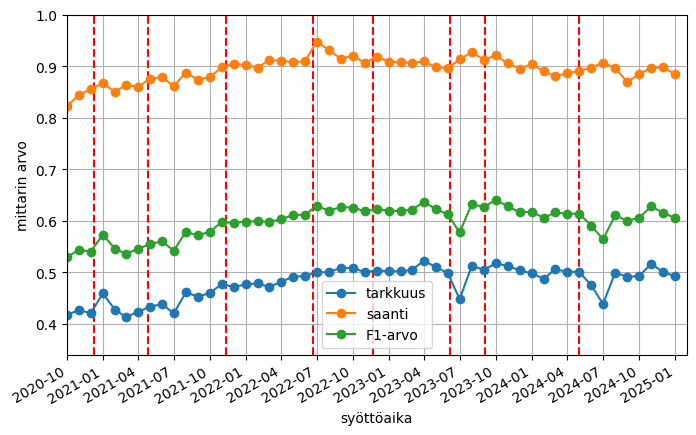

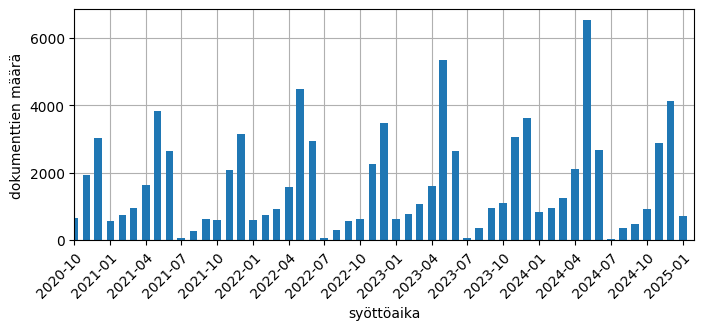

In [7]:
plt.figure(figsize=(8, 5))
plot_scores(df_fi)
plt.xlabel("syöttöaika")
plt.ylabel("mittarin arvo")
# set start of time range to 2020-09-01
plt.xlim(datetime.datetime(2020, 8, 1, tzinfo=datetime.timezone.utc))
plt.ylim(0.34, 1)

# hide legend labels of vertical lines and change other labels to finnish
plt.legend(["_"]*len(annif_updates) + ["tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", "2025-01-31", freq="3MS"))
plt.gca().set_xlim([datetime.date(2020, 10, 1), datetime.date(2025, 1, 31)])
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
# plt.savefig('kuva-1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(8, 3))
plot_counts(df_fi)
plt.xlabel("syöttöaika")
plt.ylabel("dokumenttien määrä")
plt.yticks([0, 2000, 4000, 6000])
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", "2025-01-31", freq="3MS"))
plt.gca().set_xlim([datetime.date(2020, 10, 1), datetime.date(2025, 1, 31)])
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
# rotate x tick labels
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.gca().set_axisbelow(True)
# plt.savefig('kuva-2.svg', format='svg', bbox_inches='tight')


In [8]:
# Group by annif_update and give mean precision, recall, f1
df_fi.groupby("annif_update")[['precision', 'recall', 'f1 score']].agg(['mean', 'count']).style.set_caption(title_str)

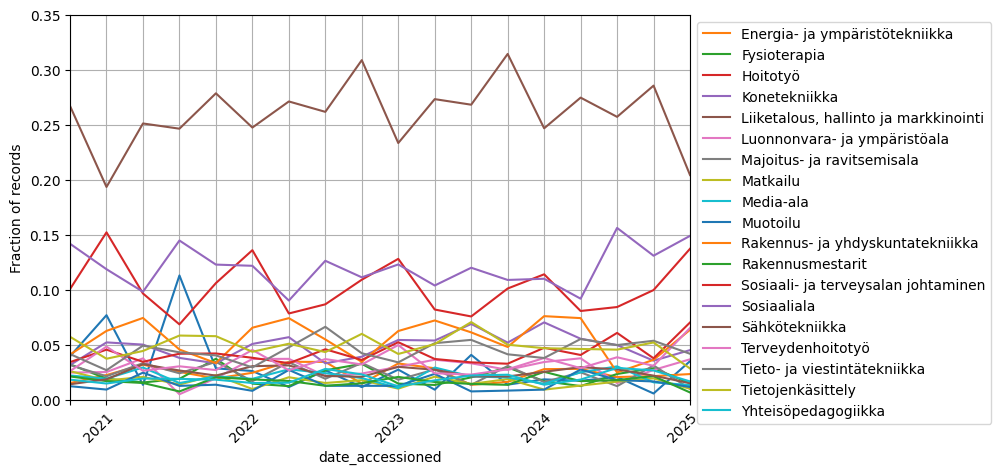

In [9]:
def plot_fraction_by_top_degreeprograms(df):
    df['degreeprogram'] = df['degreeprogram'].map(lambda x: x.split("|")[0].lstrip("fi="))
    # Identify the 20 most common degreeprograms
    top_degreeprograms = df['degreeprogram'].value_counts().nlargest(20).index

    # Filter the DataFrame to include only the top 20 degreeprograms
    df_filtered = df[df['degreeprogram'].isin(top_degreeprograms)]

    # Set the index to date_accessioned
    df_filtered = df_filtered.set_index('date_accessioned') #, inplace=True)

    # Group by degreeprogram and resample by month start
    df_monthly = df_filtered.groupby('degreeprogram').resample('QS').id.count().unstack(0)

    # Calculate the fraction of records by degreeprogram
    df_fraction = df_monthly.div(df_monthly.sum(axis=1), axis=0)

    # Plot the data
    df_fraction.plot(figsize=(8, 5)).legend(bbox_to_anchor=(1.0, 1.0),)
    plt.ylabel("Fraction of records")
    plt.grid()
    # plt.show()

plot_fraction_by_top_degreeprograms(df_fi)
plt.ylim([0, 0.35])
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", "2025-01-31", freq="QS"))
plt.gca().set_xlim([datetime.date(2020, 10, 1), datetime.date(2025, 1, 31)])
# rotate x tick labels
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.gca().set_axisbelow(True)

## Distributions
Number of records with each score value

In [10]:
df_fi['precision'].value_counts(sort=False).sort_index()

precision
0.000000      806
0.100000     2992
0.111111        8
0.125000        1
0.142857        3
0.166667        1
0.200000     8487
0.222222        6
0.250000        2
0.285714        1
0.300000    15653
0.333333       12
0.375000        3
0.400000    16049
0.428571        2
0.444444        8
0.500000    13187
0.555556        4
0.571429        1
0.600000     9779
0.625000        4
0.666667        2
0.700000     6921
0.750000        2
0.777778        2
0.800000     4729
0.833333        1
0.857143        1
0.875000        4
0.900000     3192
1.000000     4952
Name: count, dtype: int64

In [11]:
df_fi['recall'].value_counts(sort=False).sort_index()

recall
0.000000      806
0.100000        2
0.111111        1
0.125000        7
0.142857       23
            ...  
0.875000      780
0.888889      499
0.900000      369
0.909091      355
1.000000    60244
Name: count, Length: 91, dtype: int64

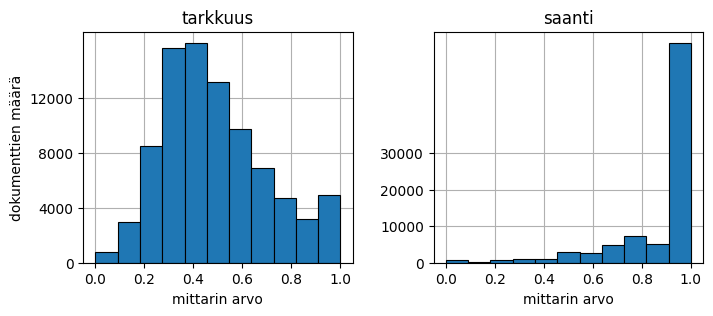

In [12]:
 # 11 bins cover all most common values of precision
df_fi[['precision', 'recall']].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.gca().set_title("saanti")
# plt.ylabel("dokumenttien määrä")
plt.xlabel("mittarin arvo")
plt.yticks([0, 10000, 20000, 30000])
# put grid behind bars
plt.gca().set_axisbelow(True)

# select axis of first subplot
plt.sca(plt.gcf().axes[0])
plt.yticks([0, 4000, 8000, 12000])
plt.gca().set_title("tarkkuus")
plt.ylabel("dokumenttien määrä")
plt.xlabel("mittarin arvo")
plt.gca().set_axisbelow(True)
plt.savefig('kuva-3.svg', format='svg', bbox_inches='tight')

The histogram of recall above indicates that nearly never users assigns subjects that
are not suggested by Annif.

In [13]:
# Records without self added subjects
len(df_fi[(df_fi.recall == 1.0)]) / len(df_fi)

0.6939353798306744

### How many Annif suggestions have been used without any manual corrections?

In [14]:
# select rows with precision = 1.0 and describe recall
df_fi[df_fi.precision == 1.0].recall.value_counts(sort=False).sort_index()

recall
0.125000       1
0.169492       1
0.256410       1
0.277778       1
0.294118       1
0.322581       4
0.333333       2
0.357143       1
0.370370       1
0.384615       2
0.400000       2
0.416667       1
0.434783       1
0.454545       2
0.476190       5
0.500000       7
0.526316       6
0.555556      11
0.588235      21
0.625000      18
0.666667      36
0.714286      62
0.769231     112
0.833333     213
0.909091     355
1.000000    4085
Name: count, dtype: int64

In [15]:
# percentage of rows with precision = 1.0 and recall = 1.0
len(df_fi[(df_fi.precision == 1.0) & (df_fi.recall == 1.0)]) / len(df_fi)

0.047054080516039855

### How many documents with all suggestions rejected?

In [16]:
df_fi[df_fi.recall == 0.0].precision.value_counts(sort=False).sort_index()

precision
0.0    806
Name: count, dtype: int64

In [17]:
len(df_fi[df_fi.recall == 0.0]) / len(df_fi)

0.009284109888844094


## How many suggestions before and after Annif integration?

In [18]:
df_fi_before = df[((df.language == 'fin') | (df.language == 'fi')) & (df.date_accessioned < "2020-09-01") & (df.date_accessioned >= "2016-01-01")]
df_fi_before = add_subjects_uris(df_fi_before, 'fi', source_col='subjects_all')
df_fi_before = df_fi_before[df_fi_before.subjects_uris.apply(lambda x: len([e for e in x if e != '']) > 0)]
len(df_fi_before)

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'


/tmp/ipykernel_2516413/2771348560.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_2516413/2771348560.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


59446

In [19]:
df_fi_before.subjects_uris.apply(lambda x: len(x)).describe()

count    59446.000000
mean         3.327356
std          2.126568
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         64.000000
Name: subjects_uris, dtype: float64

In [20]:
df_fi.subjects_uris.apply(lambda x: len(x)).describe()

count    86815.000000
mean         5.443564
std          2.501984
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         80.000000
Name: subjects_uris, dtype: float64

([<matplotlib.axis.YTick at 0x7f2e64bd8ca0>,
 [Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.1, '0.10'),
  Text(0, 0.15, '0.15'),
  Text(0, 0.2, '0.20')])

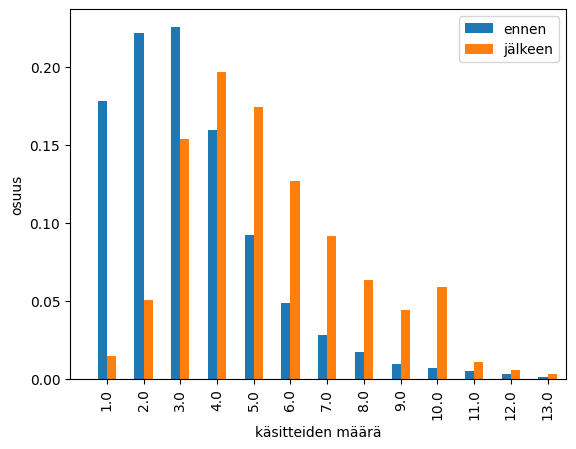

In [21]:
df_tmp = pd.DataFrame({"before": df_fi_before.subjects_uris.apply(lambda x: len(x)), "after": df_fi.subjects_uris.apply(lambda x: len(x))})
df_tmp = df_tmp.apply(pd.value_counts)
# normalize each column to sum to 1
df_tmp = df_tmp/ df_tmp.sum()
df_tmp.plot.bar()

plt.xlim(-1, 12.5)
plt.ylabel("osuus")
plt.xlabel("käsitteiden määrä")
plt.legend(["ennen", "jälkeen"])
plt.yticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%d"))

In [22]:
df_fi_both = add_subjects_uris(df[(df.language == 'fin') | (df.language == 'fi')], 'fi', source_col='subjects_all')[["subjects_uris", "date_accessioned", "suggestions"]]

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error no

/tmp/ipykernel_2516413/2771348560.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_2516413/2771348560.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


In [23]:
df_fi_just_before = df_fi_before[(df_fi_before.date_accessioned >= "2020-05-01") & (df_fi_before.date_accessioned < "2020-09-01")]
len(df_fi_just_before)


6687

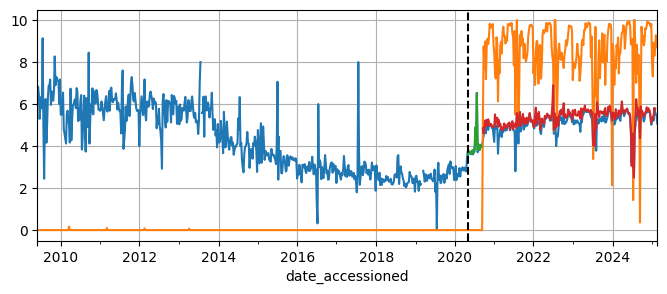

In [24]:
# plot number of subject_uris per document over time grouped by week
df_fi_both.groupby(pd.Grouper(key='date_accessioned', freq='W'))['subjects_uris'].apply(lambda x: x.apply(lambda y: len([e for e in y if e != ''])).mean()).plot(figsize=(8, 3))
df_fi_both.groupby(pd.Grouper(key='date_accessioned', freq='W'))['suggestions'].apply(lambda x: x.apply(lambda y: len([e for e in y if e != ''])).mean()).plot(figsize=(8, 3))
df_fi_just_before.groupby(pd.Grouper(key='date_accessioned', freq='W'))['subjects_uris'].apply(lambda x: x.apply(lambda y: len([e for e in y if e != ''])).mean()).plot(figsize=(8, 3))
df_fi.groupby(pd.Grouper(key='date_accessioned', freq='W'))['subjects_uris'].apply(lambda x: x.apply(lambda y: len([e for e in y if e != ''])).mean()).plot(figsize=(8, 3))

plt.grid()
# draw vertical line at 2020-05-01
plt.axvline(x="2020-05-01", color='black', linestyle='--')

For some reason the number of subjects per document started to increase before
introducing the suggestions, probably because instructions for users changed.

In [25]:
df_fi_just_before.subjects_uris.apply(lambda x: len(x)).describe()

count    6687.000000
mean        3.730372
std         1.946290
min         1.000000
25%         3.000000
50%         3.000000
75%         5.000000
max        64.000000
Name: subjects_uris, dtype: float64

## Results per degree programme

In [26]:
df_fi.degreeprogram.unique()

array(['', 'Rakennus- ja yhdyskuntatekniikka',
       'Liiketalous, hallinto ja markkinointi', 'Sosiaaliala',
       'Fysioterapia', 'Energia- ja ympäristötekniikka',
       'Teknologiaosaamisen johtaminen', 'Automaatiotekniikka',
       'Rakennusmestarit', 'Tietojenkäsittely',
       'Luonnonvara- ja ympäristöala',
       'Sosiaali- ja terveysalan johtaminen', 'Tuotantotalous', 'Poliisi',
       'Sähkötekniikka', 'Hoitotyö', 'Kulttuurituotanto',
       'Turvallisuusala', 'Konetekniikka', 'Terveydenhoitotyö',
       'Merenkulku', 'Majoitus- ja ravitsemisala',
       'Esittävä taide ja musiikki', 'Johdon assistenttityö ja kielet',
       'Tieto- ja viestintätekniikka', 'Yhteisöpedagogiikka',
       'Bio- ja elintarviketekniikka', 'LVI-tekniikka',
       'Ajoneuvo- ja kuljetustekniikka', 'Liikunta-ala', 'Muotoilu',
       'Kauneudenhoitoala', 'Laboratorioala', 'Kasvatus- ja opetusala',
       'Kemiantekniikka', 'Ensihoito ja akuutti hoitotyö', 'Logistiikka',
       'Kirjasto- ja informaa

In [27]:
df_fi[df_fi.degreeprogram == ''].type.unique()

array(['publication',
       "fi=Publisher's version|sv=Publisher's version|en=Publisher's version|",
       'julkaisusarja'], dtype=object)

In [28]:
# assign special value to empty degreeprogram
df_fi.loc[df_fi.degreeprogram == '', 'degreeprogram'] = '(Muu julkaisu)'

In [29]:
# mean precision, recall, f1 score for each degree program and sort by f1 score
df_per_dp = df_fi.groupby("degreeprogram")[['precision', 'recall', 'f1 score']].agg(['mean', 'count']).sort_values(by=('f1 score', 'mean'), ascending=False)
# rename degree program entries to take only the first part of the name
df_per_dp.index = df_per_dp.index.map(lambda x: x.split("|")[0].lstrip("fi="))

# copy to clipboard
df_per_dp[df_per_dp.precision['count'] > 400].to_clipboard()
df_per_dp[df_per_dp.precision['count'] > 400]

precision           recall         \
                                           mean  count      mean  count   
degreeprogram                                                             
Kuvataide                              0.583711    485  0.838891    485   
Esittävä taide ja musiikki             0.560699   1145  0.846535   1145   
Liikunta-ala                           0.535038    782  0.898273    782   
Kulttuurituotanto                      0.535377    783  0.861697    783   
Yhteisöpedagogiikka                    0.533135   1346  0.868444   1346   
Fysioterapia                           0.524410   1483  0.882277   1483   
Ajoneuvo- ja kuljetustekniikka         0.508318    553  0.937208    553   
(Muu julkaisu)                         0.554764   1389  0.839749   1389   
Poliisi                                0.512254   1118  0.921110   1118   
Terveydenhoitotyö                      0.518921   2090  0.895507   2090   
Toimintaterapia                        0.512777    477  0.877079    477   
Vanhustyö                              0.510166    482  0.892874    482   
Muotoilu                               0.520833   1248  0.857584   1248   
Majoitus- ja ravitsemisala             0.501171   1964  0.910839   1964   
Hoitotyö                               0.503088   6719  0.896691   6719   
Sosiaali- ja terveysalan johtaminen    0.496601   2656  0.896873   2656   
Sosiaaliala                            0.499748   7700  0.885386   7700   
Matkailu                               0.491819   1259  0.889354   1259   
Luonnonvara- ja ympäristöala           0.491636   2140  0.886220   2140   
Teknologiaosaamisen johtaminen         0.489823    821  0.904051    821   
Rakennusmestarit                       0.479686   1211  0.936425   1211   
Logistiikka                            0.476059    750  0.918028    750   
Energia- ja ympäristötekniikka         0.479551   1710  0.904374   1710   
Rakennus- ja yhdyskuntatekniikka       0.476411   4017  0.915098   4017   
Liiketalous, hallinto ja markkinointi  0.475844  18821  0.909542  18821   
Media-ala                              0.495905   1569  0.836832   1569   
LVI-tekniikka                          0.475923    569  0.878587    569   
Konetekniikka                          0.458443   3351  0.917647   3351   
Bioanalytiikka                         0.460806    546  0.879761    546   
Sähkötekniikka                         0.454150   1755  0.912893   1755   
Tuotantotalous                         0.444867    686  0.915951    686   
Automaatiotekniikka                    0.438428   1145  0.900333   1145   
Turvallisuusala                        0.435000    480  0.903308    480   
Ensihoito ja akuutti hoitotyö          0.442013    673  0.870459    673   
Tieto- ja viestintätekniikka           0.422393   3212  0.869998   3212   
Tietojenkäsittely                      0.417308   3489  0.871873   3489   

                                       f1 score         
                                           mean  count  
degreeprogram                                           
Kuvataide                              0.660809    485  
Esittävä taide ja musiikki             0.650706   1145  
Liikunta-ala                           0.643586    782  
Kulttuurituotanto                      0.636143    783  
Yhteisöpedagogiikka                    0.634714   1346  
Fysioterapia                           0.634279   1483  
Ajoneuvo- ja kuljetustekniikka         0.631900    553  
(Muu julkaisu)                         0.631778   1389  
Poliisi                                0.630747   1118  
Terveydenhoitotyö                      0.629802   2090  
Toimintaterapia                        0.623939    477  
Vanhustyö                              0.623682    482  
Muotoilu                               0.622258   1248  
Majoitus- ja ravitsemisala             0.620856   1964  
Hoitotyö                               0.620049   6719  
Sosiaali- ja terveysalan johtaminen    0.613932   2656  
Sosiaaliala                  

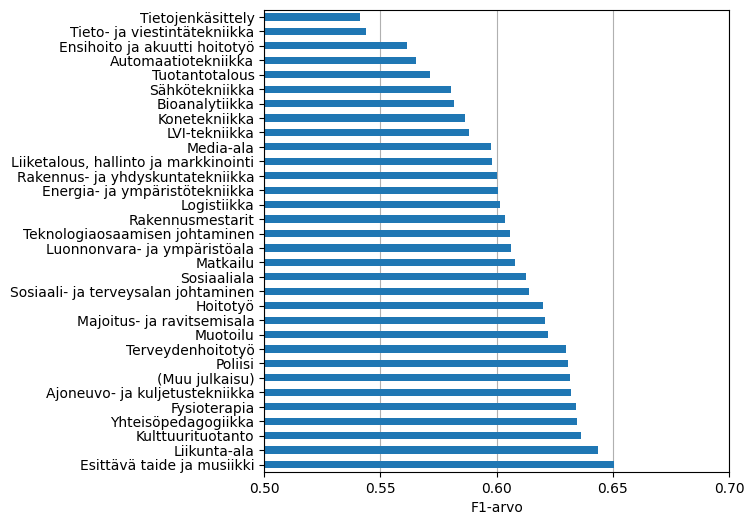

In [30]:
df_per_dp[df_per_dp.precision['count'] > 500]['f1 score']['mean'].plot.barh(figsize=(6, 6))
plt.ylabel(None)
plt.xlim(0.5, 0.7)
plt.xticks(np.arange(0.5, 0.75, 0.05))
plt.xlabel("F1-arvo")
plt.grid(axis='x')
plt.gca().set_axisbelow(True)
# plt.savefig('kuva-4.svg', format='svg', bbox_inches='tight')

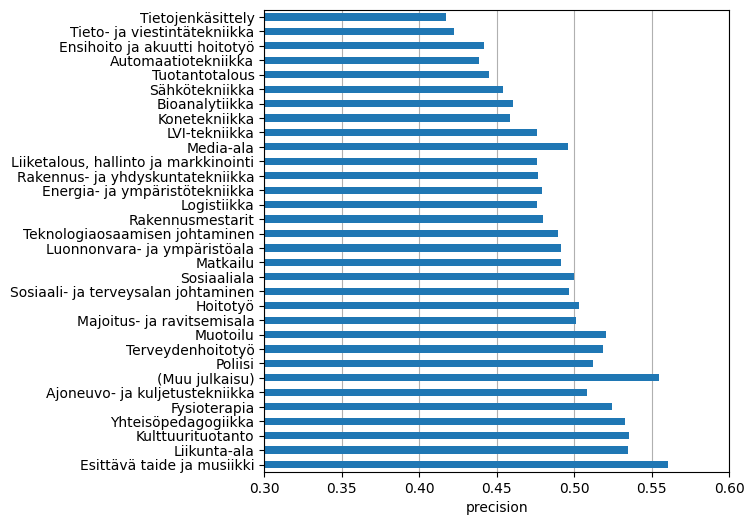

In [31]:
df_per_dp[df_per_dp.precision['count'] > 500]['precision']['mean'].plot.barh(figsize=(6, 6))
plt.ylabel(None)
plt.xlim(0.3, 0.6)
# plt.xticks(pd.np.arange(0.5, 0.75, 0.05))
plt.xlabel("precision")
plt.grid(axis='x')
plt.gca().set_axisbelow(True)

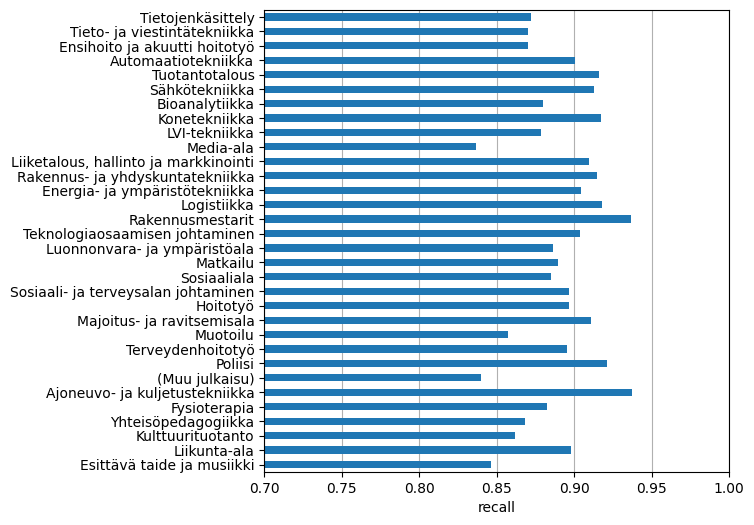

In [32]:
df_per_dp[df_per_dp.precision['count'] > 500]['recall']['mean'].plot.barh(figsize=(6, 6))
plt.ylabel(None)
plt.xlim(0.7, 1)
# plt.xticks(pd.np.arange(0.5, 0.75, 0.05))
plt.xlabel("recall")
plt.grid(axis='x')
plt.gca().set_axisbelow(True)

### (Distribution of precision and recall of some degree programs)

Text(0.5, 0.98, '(Muu julkaisu) precision mean: 0.55 recall mean: 0.83')

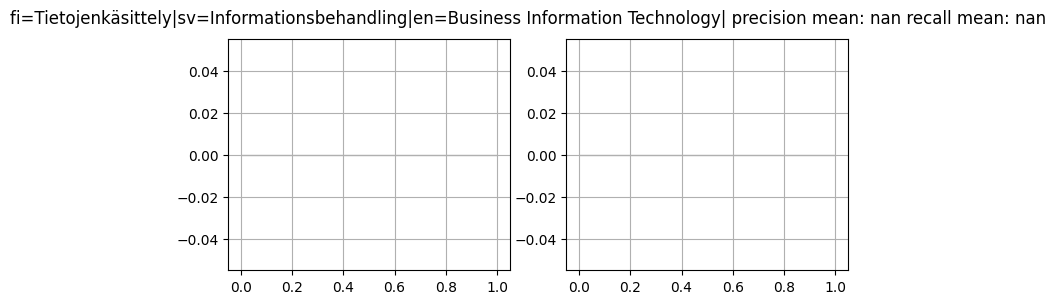

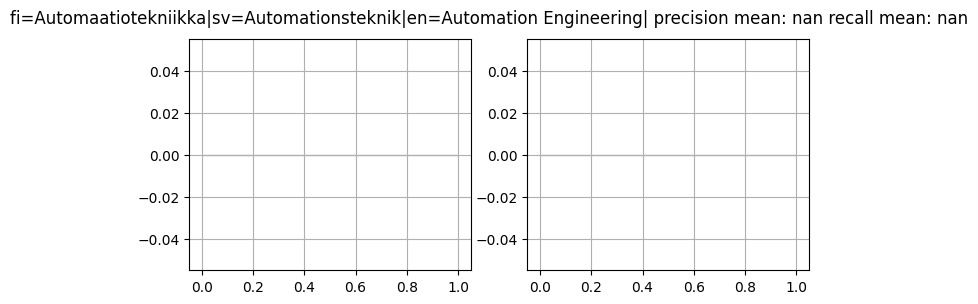

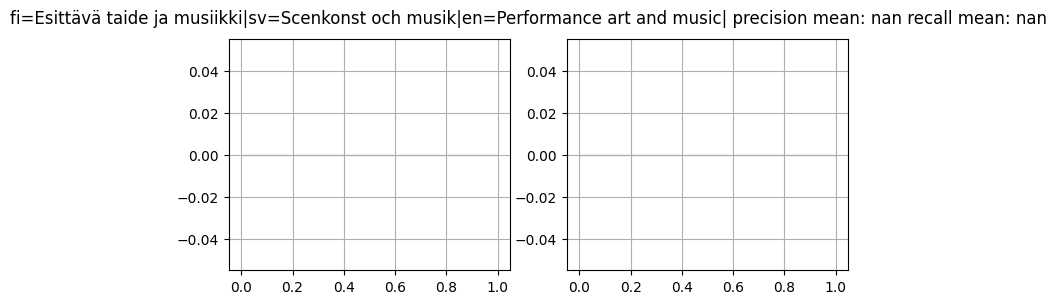

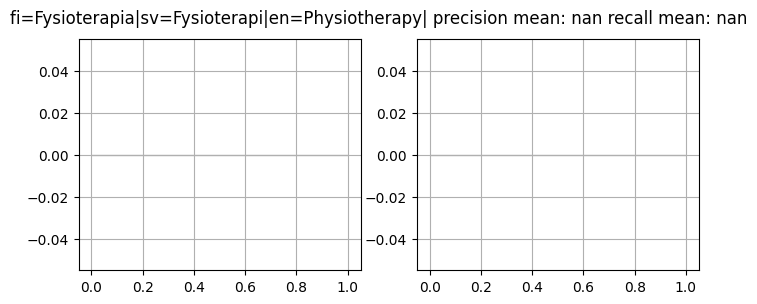

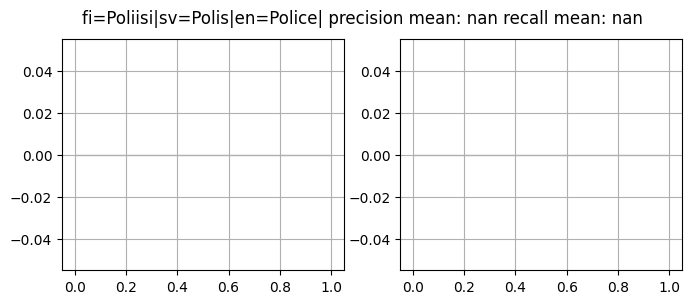

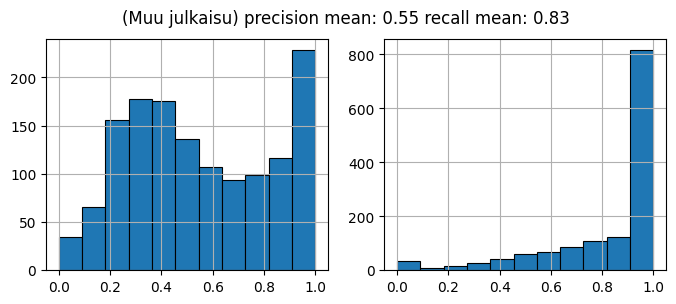

In [33]:
plt.figure()
dp = 'fi=Tietojenkäsittely|sv=Informationsbehandling|en=Business Information Technology|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4])

plt.figure()
dp = 'fi=Automaatiotekniikka|sv=Automationsteknik|en=Automation Engineering|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4])

plt.figure()
dp = 'fi=Esittävä taide ja musiikki|sv=Scenkonst och musik|en=Performance art and music|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4])

plt.figure()
dp = 'fi=Fysioterapia|sv=Fysioterapi|en=Physiotherapy|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4])
plt.figure()

dp = 'fi=Poliisi|sv=Polis|en=Police|'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4])

plt.figure()
dp = '(Muu julkaisu)'
plt.subplot(1,2,1)
df_fi[df_fi.degreeprogram == dp]['precision'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.subplot(1,2,2)
df_fi[df_fi.degreeprogram == dp]['recall'].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.suptitle(dp + ' precision mean: ' + str(df_fi[df_fi.degreeprogram == dp]['precision'].mean())[:4] + ' recall mean: ' + str(df_fi[df_fi.degreeprogram == dp]['recall'].mean())[:4])


# (Correlation of F1 score in JYX test set and in Theseus)

In [34]:
df_theseus_updates = df_fi.groupby("annif_update")[['precision', 'recall', 'f1 score']].agg(['mean', 'count'])
# index with month precision
df_theseus_updates.index = df_theseus_updates.index.map(lambda x: x.date())
df_theseus_updates

precision           recall         f1 score       
                  mean  count      mean  count      mean  count
annif_update                                                   
2020-03-26    0.421948   4078  0.845316   4078  0.539603   4078
2020-12-09    0.424670   5265  0.857507   5265  0.544088   5265
2021-04-27    0.438510   8883  0.876768   8883  0.559927   8883
2021-11-11    0.482977  15964  0.906894  15964  0.604443  15964
2022-06-21    0.507866   2695  0.913798   2695  0.624792   2695
2022-11-22    0.506350  15232  0.906036  15232  0.622154  15232
2023-06-06    0.505996   2068  0.907153   2068  0.621074   2068
2023-09-04    0.505469  13878  0.898300  13878  0.620717  13878
2024-05-02    0.498539  18745  0.893407  18745  0.611975  18745

In [35]:
df_jyx_updates = pd.DataFrame({"f1 score":
                               [0.4288, 0.4746, 0.4929, 0.5445, 0.5169, 0.5188, 0.5201, 0.5194, 0.5239, ]},
                              index=df_theseus_updates.index)
                              # pd.to_datetime(
                              #   ["2020-03-01", "2020-12-01", "2021-04-01", "2021-09-01", "2022-05-01", "2022-11-01"]))
df_jyx_updates

,f1 score
annif_update,
2020-03-26,0.4288
2020-12-09,0.4746
2021-04-27,0.4929
2021-11-11,0.5445
2022-06-21,0.5169
2022-11-22,0.5188
2023-06-06,0.5201
2023-09-04,0.5194
2024-05-02,0.5239


Text(0, 0.5, 'JYX')

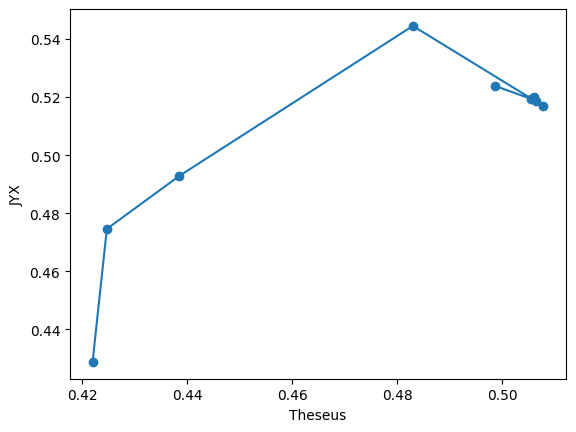

In [36]:
plt.plot(df_theseus_updates.precision['mean'], df_jyx_updates, '-o')
plt.xlabel("Theseus")
plt.ylabel("JYX")